# REGRESSION: Bitcoin Price Forecast

***


## INTRODUCTION

This project used data from <b style="color:#4361ee">Kraken API</b> and initially applid one machine learning model, <b style="color:#4361ee">Support Vector Machine</b>, to forcast the future price of <b style="color:#4361ee">Bitcoin.</b>

In [158]:
import numpy as np
import pandas as pd
import json
import datetime
import time
import requests

In [159]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams["font.size"]=14
matplotlib.rcParams["figure.figsize"]= (18,8)
matplotlib.rcParams["figure.facecolor"]="#00000000"

import seaborn as sns
sns.set_style("darkgrid")
import plotly.express as px

## DATA COLLECTION

Kraken gives historical cryptocurrency data. However, the current historical data available is March 31, 2022.
Therefore, additional data need to be pulled from the API market data endpoint.

### 1. Kraken Historical OHLCVT 

* https://support.kraken.com/hc/en-us/articles/360047124832-Downloadable-historical-OHLCVT-Open-High-Low-Close-Volume-Trades-data

* The data given is in one minute timeframe, so we will use the 1440 (daily timeframe)
* The date is in Unix timestamp, so need to be converted to regular date time 

In [160]:
# The columns from the csv file
xbt_cols = ["date","open", "high", "low", "close", "volume", "trades"]

In [161]:
xbt_raw = pd.read_csv("data/XBTUSD_1440.csv", names=xbt_cols)

In [162]:
# Convert Unix timestamp
xbt_raw["date"] = pd.to_datetime(xbt_raw["date"],unit='s')

In [163]:
xbt_raw.to_csv("data/xbt_raw.csv")

### 2. Kraken API Market data OHLC endpoint
* Using OHLC endpoint for 2022 data
* https://docs.kraken.com/rest/#operation/getTickerInformation
* Unix timestamp converter https://www.epochconverter.com/

In [164]:
# The columns from OHLC API (different from historical data)

kraken_ohlc_cols = ["date","open", "high", "low", "close", "vwap","volume", "trades"]

* Without specifying "since" parameter, the response will give the current day data and only 720 data available

In [165]:
resp = requests.get('https://api.kraken.com/0/public/OHLC?pair=XBTUSD&interval=1440&since=unix_now').json()

In [166]:
xbt_apr22_df = pd.DataFrame(resp["result"]['XXBTZUSD'])

In [167]:
xbt_apr22_df.columns = kraken_ohlc_cols

In [168]:
xbt_apr22_df["date"] = pd.to_datetime(xbt_apr22_df["date"],unit='s')
xbt_apr22_df.head(3)

,date,open,high,low,close,vwap,volume,trades
0,2020-06-16,9425.3,9593.0,9385.0,9528.5,9494.5,5563.38048246,19545
1,2020-06-17,9527.5,9556.8,9233.4,9453.1,9410.7,5393.86904625,19149
2,2020-06-18,9453.1,9480.0,9268.2,9381.5,9387.1,3652.89691828,15791


In [169]:
xbt_apr22_df.tail(3)

,date,open,high,low,close,vwap,volume,trades
717,2022-06-03,30431.3,30658.9,29255.0,29676.4,29742.1,2472.70542000,18044
718,2022-06-04,29676.4,29954.5,29450.1,29850.0,29693.4,783.34433714,10432
719,2022-06-05,29850.8,29876.3,29657.5,29768.3,29730.6,24.56655087,1188


### Appending data from OHLC API to dataframe from historical data

<b>Drop vwap column since there's no vwap column in the historical data</b>

In [170]:
# Drop vwap column since there's no vwap column in the historical data

xbt_apr22_df.drop("vwap", axis=1, inplace=True)
xbt_apr22_df.head(3)

,date,open,high,low,close,volume,trades
0,2020-06-16,9425.3,9593.0,9385.0,9528.5,5563.38048246,19545
1,2020-06-17,9527.5,9556.8,9233.4,9453.1,5393.86904625,19149
2,2020-06-18,9453.1,9480.0,9268.2,9381.5,3652.89691828,15791


<b> Select the data after March 31,2022 </b>

In [171]:
xbt_apr22 = xbt_apr22_df[xbt_apr22_df["date"] > "2022-03-31"]

<b> Combine the two dataframes</b>

In [172]:
btc_df_raw = pd.concat([xbt_raw, xbt_apr22],ignore_index=True)

In [173]:
btc_df_raw.head(3)

,date,open,high,low,close,volume,trades
0,2013-10-06,122.0,122.0,122.0,122.0,0.1,1
1,2013-10-07,123.61,123.61,123.61,123.61,0.1,1
2,2013-10-08,123.91,124.19,123.9,124.18,3.9916,4


In [174]:
btc_df_raw.tail(3)

,date,open,high,low,close,volume,trades
3150,2022-06-03,30431.3,30658.9,29255.0,29676.4,2472.70542000,18044
3151,2022-06-04,29676.4,29954.5,29450.1,29850.0,783.34433714,10432
3152,2022-06-05,29850.8,29876.3,29657.5,29768.3,24.56655087,1188


In [175]:
btc_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3153 entries, 0 to 3152
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3153 non-null   datetime64[ns]
 1   open    3153 non-null   object        
 2   high    3153 non-null   object        
 3   low     3153 non-null   object        
 4   close   3153 non-null   object        
 5   volume  3153 non-null   object        
 6   trades  3153 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 172.6+ KB


In [176]:
btc_df_raw = btc_df_raw.astype({"open":"float64", 
                               "high":"float64", 
                                "low":"float64", 
                               "close":"float64", 
                             "volume":"float64"})

In [177]:
btc_df_raw.to_csv("data/btc_df_raw.csv") # save data for later use


## DATA PREPROCESSING


### Create more features 

In [178]:
btc_df = pd.read_csv("data/btc_df_raw.csv", index_col=0)

In [179]:
btc_df.head(2)

,date,open,high,low,close,volume,trades
0,2013-10-06,122.00,122.00,122.00,122.00,0.1,1
1,2013-10-07,123.61,123.61,123.61,123.61,0.1,1


In [180]:
btc_df.tail(2)

,date,open,high,low,close,volume,trades
3151,2022-06-04,29676.4,29954.5,29450.1,29850.0,783.344337,10432
3152,2022-06-05,29850.8,29876.3,29657.5,29768.3,24.566551,1188


In [181]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3153 entries, 0 to 3152
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3153 non-null   object 
 1   open    3153 non-null   float64
 2   high    3153 non-null   float64
 3   low     3153 non-null   float64
 4   close   3153 non-null   float64
 5   volume  3153 non-null   float64
 6   trades  3153 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 197.1+ KB


#### Split date column to year, month, day

In [182]:
def date_split(df):
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    return(df)

In [183]:
btc_df = date_split(btc_df)

In [184]:
btc_df = btc_df[["date","year", "month", "day", "open", "high", "low", "close", "volume", "trades"]]

In [185]:
btc_df.head(3)

,date,year,month,day,open,high,low,close,volume,trades
0,2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1
1,2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1
2,2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4


In [186]:
btc_df = btc_df.set_index("date")

In [187]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades
date,,,,,,,,,
2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1
2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1
2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4


#### Adding Yesterday prices, volume, trades

In [188]:
def yesterday_data(df):
    df["open_yesterday"] = df["open"].shift(1)
    df["high_yesterday"] = df["high"].shift(1)
    df["low_yesterday"] = df["low"].shift(1)
    df["close_yesterday"] = df["close"].shift(1)
    df["volume_yesterday"] = df["volume"].shift(1)
    df["trades_yesterday"] = df["trades"].shift(1)
    return(df)

In [189]:
btc_df = yesterday_data(btc_df)

#### Adding % change of yesterday and the day before yesterday

price_1D_change = (today_price - yesterday_price)/yesterday_price

In [190]:
def change_1D(df):
    df["open_1D_change"] = btc_df["open"].pct_change().shift(1)
    df["high_1D_change"] = btc_df["high"].pct_change().shift(1)
    df["low_1D_change"]  = df["low"].pct_change().shift(1)
    df["close_1D_change"] = df["close"].pct_change().shift(1)
    df["volume_1D_change"] = df["volume"].pct_change().shift(1)
    df["trades_1D_change"] = df["trades"].pct_change().shift(1)
    return(df)
    

In [191]:
btc_df = change_1D(btc_df)

#### Average 7 days

- rolling will include the current row to calculate
- so if we are at row#8 (index=7), we can calculate mean of the first 7 rows 
- then shiff the value to row#8

In [192]:
def moving_ave_7(df):
    df["open_average_7D"] = df["open"].rolling(7).mean().shift(1)
    df["high_average_7D"] = df["high"].rolling(7).mean().shift(1)
    df["low_average_7D"] = df["low"].rolling(7).mean().shift(1)
    df["close_average_7D"] = df["close"].rolling(7).mean().shift(1)
    df["volume_average_7D"] = df["volume"].rolling(7).mean().shift(1)
    df["trades_average_7D"] = df["trades"].rolling(7).mean().shift(1)
    
    return(df)

In [193]:
btc_df = moving_ave_7(btc_df)

#### % change 7 days

In [194]:
def change_pct_7D(df):
    df["open_%change_7D"] = df["open_1D_change"].rolling(7).mean().shift(1)
    df["high_%change_7D"] = df["high_1D_change"].rolling(7).mean().shift(1)
    df["low_%change_7D"] = df["low_1D_change"].rolling(7).mean().shift(1)
    df["close_%change_7D"] = df["close_1D_change"].rolling(7).mean().shift(1)
    df["volume_%change_7D"] = df["volume_1D_change"].rolling(7).mean().shift(1)
    df["trades_%change_7D"] = df["trades_1D_change"].rolling(7).mean().shift(1)
    
    return(df)

In [195]:
btc_df = change_pct_7D(btc_df)

#### Simple Moving Average 9, 20, 50
- Will only use ["close"] here

In [196]:
def moving_avgs_pop(df):
    df["moving_average_9"] = df["close"].rolling(9).mean().shift(1)
    df["moving_average_20"] = df["close"].rolling(20).mean().shift(1)
    df["moving_average_50"] = df["close"].rolling(50).mean().shift(1)
    
    return(df)

In [197]:
btc_df = moving_avgs_pop(btc_df)

<b> Set the display to see all columns </b>

In [198]:
pd.set_option("display.max_columns", len(btc_df.columns))

In [199]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1,122.00,122.00,122.00,122.00,0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4,123.61,123.61,123.61,123.61,0.1,1.0,0.013197,0.013197,0.013197,0.013197,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-03,2022,6,3,30431.3,30658.9,29255.0,29676.4,2472.705420,18044,29790.0,31449.2,29572.8,30427.0,2470.229023,19405.0,-0.062647,-0.015027,0.008326,0.021383,-0.522312,-0.381672,29928.271429,30876.442857,29276.714286,30108.571429,3377.918417,24755.571429,0.010495,0.008596,0.001014,0.002066,0.498077,0.160941,29940.800000,29876.625,34388.020
2022-06-04,2022,6,4,29676.4,29954.5,29450.1,29850.0,783.344337,10432,30431.3,30658.9,29255.0,29676.4,2472.705420,18044.0,0.021527,-0.025129,-0.010746,-0.024669,0.001002,-0.070137,30109.042857,31058.214286,29420.285714,30265.200000,3100.954225,23052.571429,0.002069,0.008034,0.010997,0.006734,0.315893,0.029863,29958.144444,29858.035,34182.450
2022-06-05,2022,6,5,29850.8,29876.3,29657.5,29768.3,24.566551,1188,29676.4,29954.5,29450.1,29850.0,783.344337,10432.0,-0.024807,-0.022975,0.006669,0.005850,-0.683204,-0.421858,30265.671429,31161.857143,29556.000000,30383.771429,3044.968723,22382.000000,0.006855,0.006682,0.005592,0.006180,0.331916,0.016631,30031.822222,29785.690,33968.052


#### Drop NaN

In [201]:
len(btc_df)

3153

In [202]:
btc_df = btc_df.dropna()

In [203]:
len(btc_df)

3103

In [204]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [205]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-03,2022,6,3,30431.3,30658.9,29255.0,29676.4,2472.705420,18044,29790.0,31449.2,29572.8,30427.0,2470.229023,19405.0,-0.062647,-0.015027,0.008326,0.021383,-0.522312,-0.381672,29928.271429,30876.442857,29276.714286,30108.571429,3377.918417,24755.571429,0.010495,0.008596,0.001014,0.002066,0.498077,0.160941,29940.800000,29876.625,34388.020
2022-06-04,2022,6,4,29676.4,29954.5,29450.1,29850.0,783.344337,10432,30431.3,30658.9,29255.0,29676.4,2472.705420,18044.0,0.021527,-0.025129,-0.010746,-0.024669,0.001002,-0.070137,30109.042857,31058.214286,29420.285714,30265.200000,3100.954225,23052.571429,0.002069,0.008034,0.010997,0.006734,0.315893,0.029863,29958.144444,29858.035,34182.450
2022-06-05,2022,6,5,29850.8,29876.3,29657.5,29768.3,24.566551,1188,29676.4,29954.5,29450.1,29850.0,783.344337,10432.0,-0.024807,-0.022975,0.006669,0.005850,-0.683204,-0.421858,30265.671429,31161.857143,29556.000000,30383.771429,3044.968723,22382.000000,0.006855,0.006682,0.005592,0.006180,0.331916,0.016631,30031.822222,29785.690,33968.052


#### Save dataframe for later use for Machine Learaning model

In [206]:
btc_df.to_csv("data/btc_df.csv")

# VISUALIZATION

In [207]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [208]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-03,2022,6,3,30431.3,30658.9,29255.0,29676.4,2472.705420,18044,29790.0,31449.2,29572.8,30427.0,2470.229023,19405.0,-0.062647,-0.015027,0.008326,0.021383,-0.522312,-0.381672,29928.271429,30876.442857,29276.714286,30108.571429,3377.918417,24755.571429,0.010495,0.008596,0.001014,0.002066,0.498077,0.160941,29940.800000,29876.625,34388.020
2022-06-04,2022,6,4,29676.4,29954.5,29450.1,29850.0,783.344337,10432,30431.3,30658.9,29255.0,29676.4,2472.705420,18044.0,0.021527,-0.025129,-0.010746,-0.024669,0.001002,-0.070137,30109.042857,31058.214286,29420.285714,30265.200000,3100.954225,23052.571429,0.002069,0.008034,0.010997,0.006734,0.315893,0.029863,29958.144444,29858.035,34182.450
2022-06-05,2022,6,5,29850.8,29876.3,29657.5,29768.3,24.566551,1188,29676.4,29954.5,29450.1,29850.0,783.344337,10432.0,-0.024807,-0.022975,0.006669,0.005850,-0.683204,-0.421858,30265.671429,31161.857143,29556.000000,30383.771429,3044.968723,22382.000000,0.006855,0.006682,0.005592,0.006180,0.331916,0.016631,30031.822222,29785.690,33968.052


In [209]:
btc_df_viz = btc_df[:-1]  # drop last row because the trading day isn't closed yet

In [210]:
btc_df_viz.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [211]:
btc_df_viz.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-02,2022,6,2,29790.0,31449.2,29572.8,30427.0,2470.229023,19405,31781.0,31929.0,29328.6,29790.0,5171.217781,31383.0,0.002226,-0.014537,-0.059489,-0.062645,0.489934,0.017904,29889.614286,30648.557143,28981.314286,29931.414286,3734.049740,26170.000000,0.012919,0.012442,0.012874,0.010477,0.429364,0.159159,29852.444444,29816.405,34602.48
2022-06-03,2022,6,3,30431.3,30658.9,29255.0,29676.4,2472.705420,18044,29790.0,31449.2,29572.8,30427.0,2470.229023,19405.0,-0.062647,-0.015027,0.008326,0.021383,-0.522312,-0.381672,29928.271429,30876.442857,29276.714286,30108.571429,3377.918417,24755.571429,0.010495,0.008596,0.001014,0.002066,0.498077,0.160941,29940.800000,29876.625,34388.02
2022-06-04,2022,6,4,29676.4,29954.5,29450.1,29850.0,783.344337,10432,30431.3,30658.9,29255.0,29676.4,2472.705420,18044.0,0.021527,-0.025129,-0.010746,-0.024669,0.001002,-0.070137,30109.042857,31058.214286,29420.285714,30265.200000,3100.954225,23052.571429,0.002069,0.008034,0.010997,0.006734,0.315893,0.029863,29958.144444,29858.035,34182.45


<b> Close Price Trend </b>

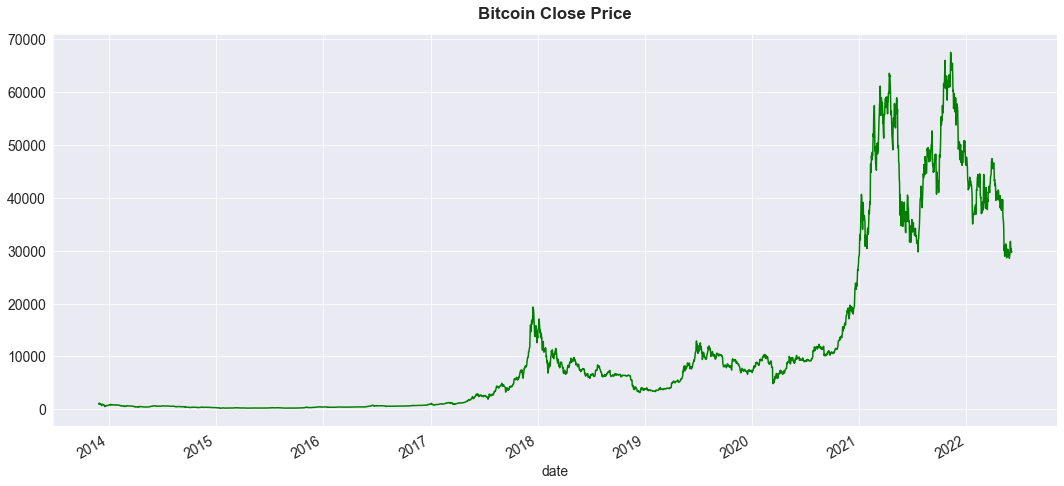

In [212]:
btc_df_viz['close'].plot(color="green") 
plt.title("Bitcoin Close Price", fontweight="bold", y=1.025)#fontname="Times New Roman"
plt.show()

<b> Volume Trend </b>

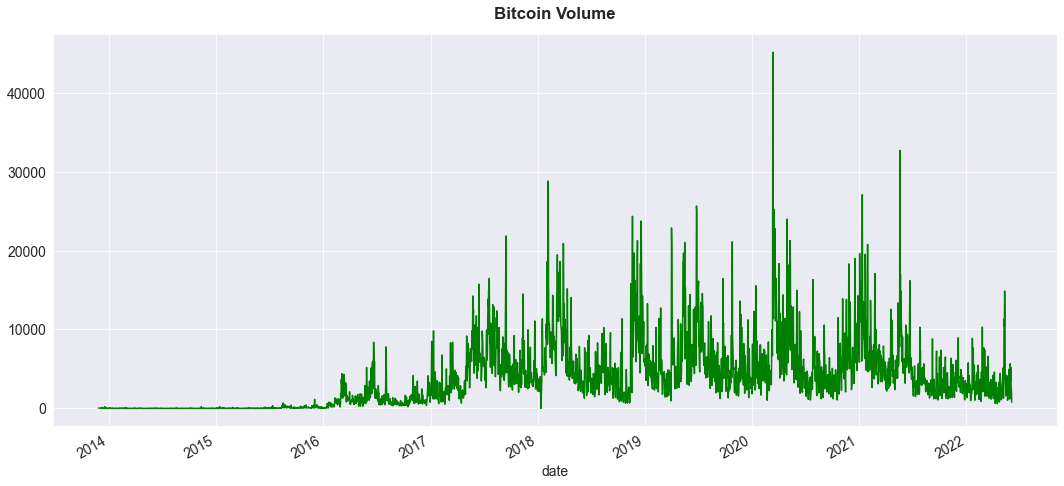

In [213]:
btc_df_viz['volume'].plot(color="green")
plt.title("Bitcoin Volume", fontweight="bold", y=1.025)
plt.show()

<b> Trades Trend </b>

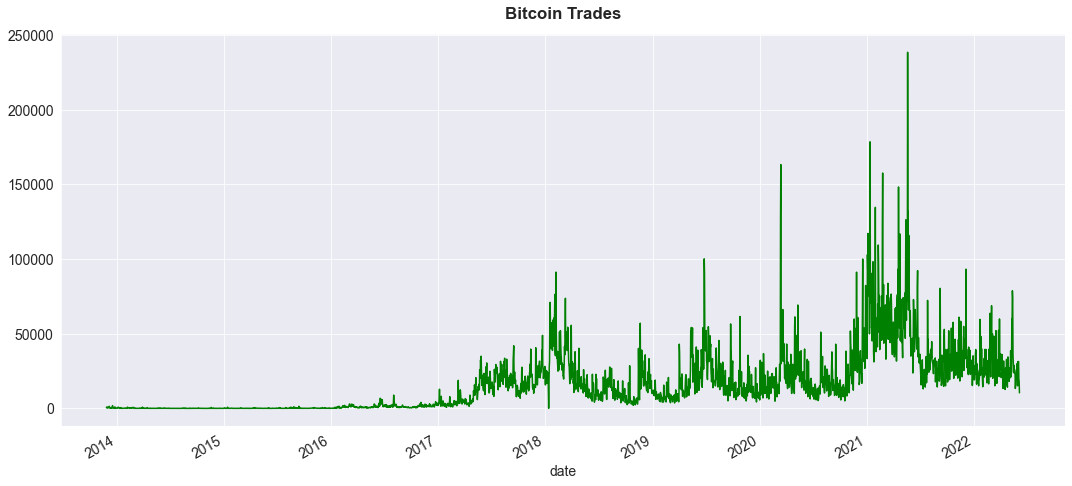

In [214]:
btc_df_viz['trades'].plot(color="green")
plt.title("Bitcoin Trades", fontweight="bold", y=1.025)
plt.show()

<b> Box Plot Close Price </b>

Text(0, 0.5, '')

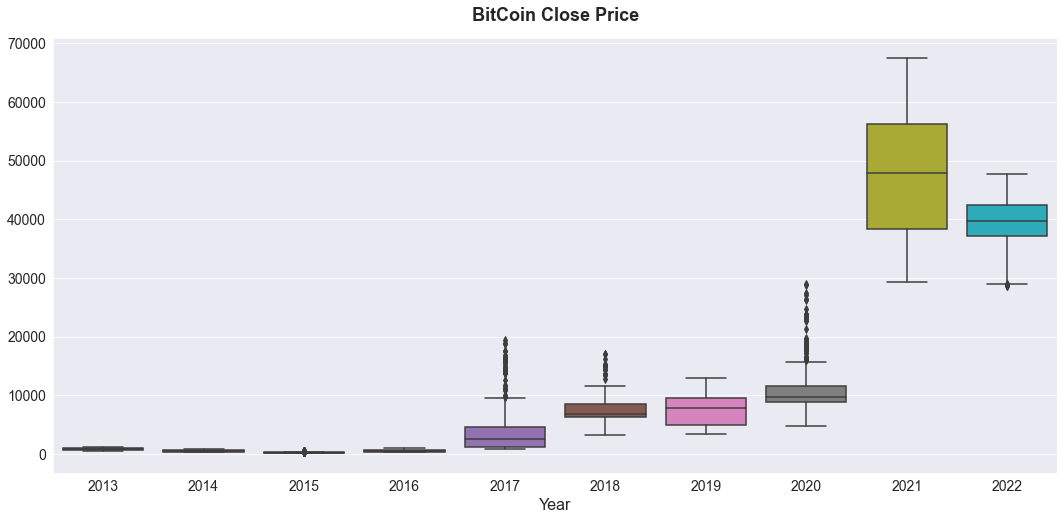

In [215]:
box = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["close"], data=btc_df_viz)

box.set_title("BitCoin Close Price",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box.set_xlabel("Year", fontsize=16)
box.set_ylabel(None, fontsize=16)


<b> Box Plot Volume </b>

Text(0, 0.5, '')

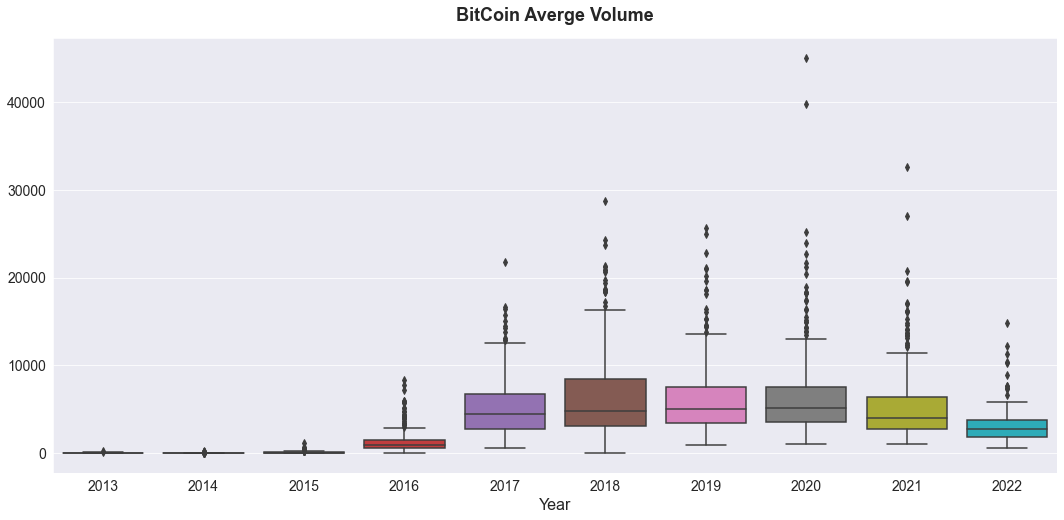

In [216]:
box1 = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["volume"], data=btc_df_viz)

box1.set_title("BitCoin Averge Volume",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box1.set_xlabel("Year", fontsize=16)
box1.set_ylabel(None, fontsize=16)


<b> Box Plot Trades </b>

Text(0, 0.5, '')

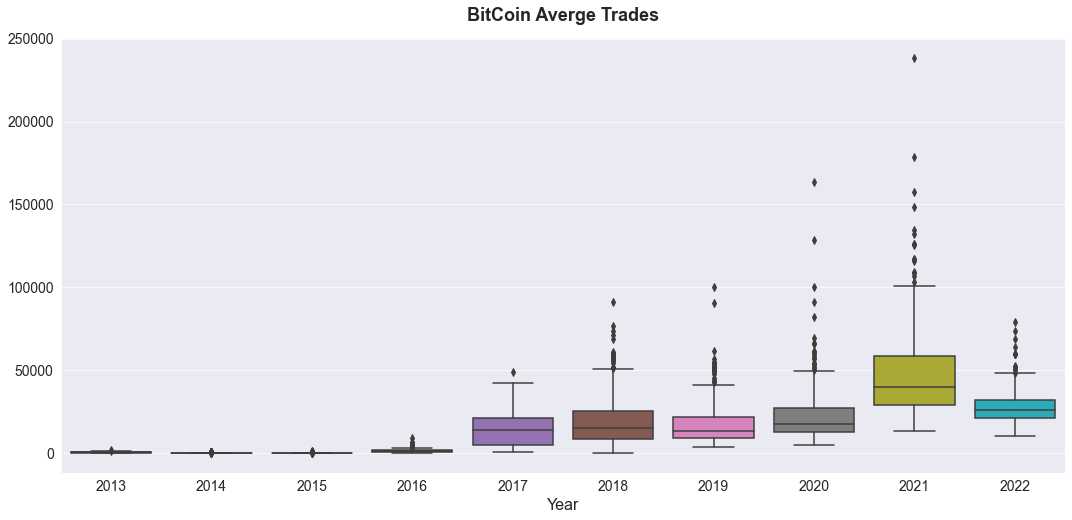

In [217]:
box2 = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["trades"], data=btc_df_viz)

box2.set_title("BitCoin Averge Trades",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box2.set_xlabel("Year", fontsize=16)
box2.set_ylabel(None, fontsize=16)

#### 2022 Monthly Close Price 

In [218]:
btc_df_viz_2022 = btc_df_viz[:]

In [219]:
filt = btc_df_viz_2022["year"]='2022'

In [220]:
btc_df_viz_2022 = btc_df_viz_2022[filt]

/var/folders/77/506sgzjs15b84ns9yp8cp2rc0000gn/T/ipykernel_30974/3275679836.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  btc_df_viz_2022 = btc_df_viz_2022[filt]


Text(0, 0.5, '')

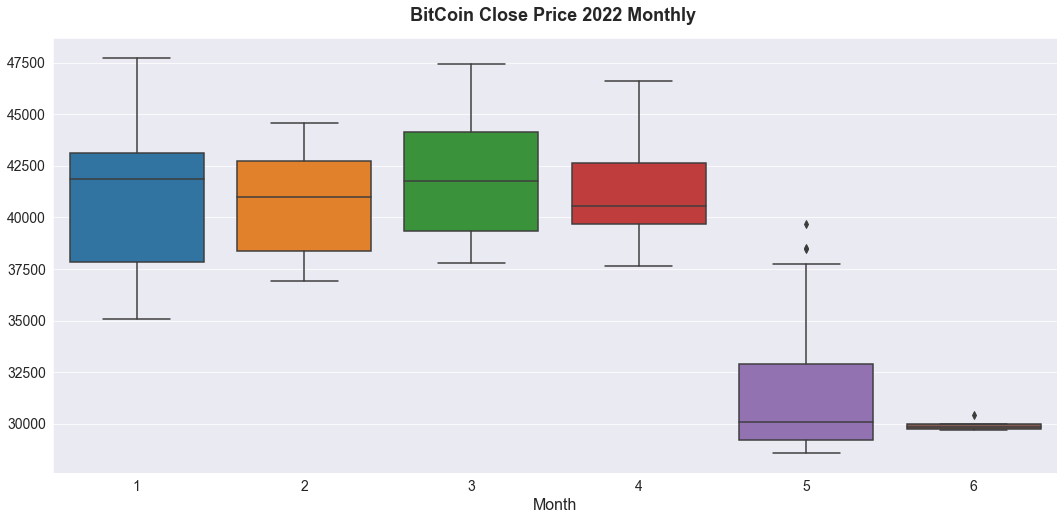

In [221]:
box = sns.boxplot(x=btc_df_viz_2022["month"], y=btc_df_viz_2022["close"], data=btc_df_viz_2022)

box.set_title("BitCoin Close Price 2022 Monthly ",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box.set_xlabel("Month", fontsize=16)
box.set_ylabel(None, fontsize=16)

In [222]:
btc_df_viz = btc_df_viz.astype({"year":"int"})

In [223]:
btc_avg = btc_df_viz[:]
btc_avg

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814
2013-11-30,2013,11,30,1155.62219,1189.10145,1094.38283,1114.24001,22.761523,365,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562.0,0.017532,0.101419,0.082680,0.165042,0.054402,0.268623,877.595607,975.675600,837.885186,927.895049,27.908455,393.428571,0.077430,0.064616,0.072709,0.061428,0.299319,0.216921,884.654620,650.853472,375.012714
2013-12-01,2013,12,1,1112.01598,1130.00000,770.00000,953.72943,52.505576,905,1155.62219,1189.10145,1094.38283,1114.24001,22.761523,365.0,0.141476,-0.008091,0.080986,-0.043920,-0.346446,-0.350534,928.920399,1016.393450,884.402399,968.392544,25.006714,412.571429,0.062716,0.061247,0.069921,0.058034,0.414079,0.270971,934.007908,690.715473,394.820714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,2022,5,31,31710.40000,32400.00000,31183.70000,31780.90000,3470.770769,30831,29450.50000,32186.40000,29281.80000,31711.70000,5654.097225,31318.0,0.014831,0.089034,0.016024,0.076783,3.374826,1.052159,29204.842857,30031.357143,28614.457143,29585.871429,3304.828668,22719.285714,-0.001572,-0.004396,-0.001593,-0.003697,0.081372,0.050747,29604.344444,29634.735000,34963.328000
2022-06-01,2022,6,1,31781.00000,31929.00000,29328.60000,29790.00000,5171.217781,31383,31710.40000,32400.00000,31183.70000,31780.90000,3470.770769,30831.0,0.076736,0.006636,0.064952,0.002182,-0.386149,-0.015550,29582.042857,30399.971429,28978.514286,29892.885714,3399.771350,24412.571429,-0.003681,0.007711,0.002632,0.012926,0.474022,0.138363,29772.444444,29774.075000,34808.254000
2022-06-02,2022,6,2,29790.00000,31449.20000,29572.80000,30427.00000,2470.229023,19405,31781.00000,31929.00000,29328.60000,29790.00000,5171.217781,31383.0,0.002226,-0.014537,-0.059489,-0.062645,0.489934,0.017904,29889.614286,30648.557143,28981.314286,29931.414286,3734.049740,26170.000000,0.012919,0.012442,0.012874,0.010477,0.429364,0.159159,29852.444444,29816.405000,34602.480000


In [224]:
btc_avg = pd.DataFrame(btc_df_viz.groupby(['year'])['open'].mean())
btc_avg["high"] = pd.DataFrame(btc_df_viz.groupby(['year'])['high'].mean())
btc_avg["low"] = pd.DataFrame(btc_df_viz.groupby(['year'])['low'].mean())
btc_avg["close"] = pd.DataFrame(btc_df_viz.groupby(['year'])['close'].mean())
btc_avg["volume"] = pd.DataFrame(btc_df_viz.groupby(['year'])['volume'].mean())
btc_avg["trades"] = pd.DataFrame(btc_df_viz.groupby(['year'])['trades'].mean())
btc_avg

,open,high,low,close,volume,trades
year,,,,,,
2013,834.430256,887.545685,763.786884,828.310699,43.388851,489.028571
2014,533.016193,548.639927,515.940908,531.499985,14.195329,102.535211
2015,271.471425,278.831813,265.153542,272.323858,77.278983,122.101370
2016,566.870884,576.048015,557.450315,568.276695,1283.666737,1306.759563
2017,3936.776534,4118.183701,3767.023499,3972.502397,5048.121496,14161.161644
2018,7552.732329,7783.027671,7258.388493,7523.407671,6301.052699,19339.312329
2019,7355.562466,7562.660548,7131.104658,7364.964110,6106.849901,17539.893151
2020,11056.251366,11336.646721,10783.763934,11116.068579,6386.292323,22526.715847
2021,47378.112329,48812.425753,45668.609041,47426.086301,5254.154224,47278.846575


<b>Yearly Average Close Price </b>

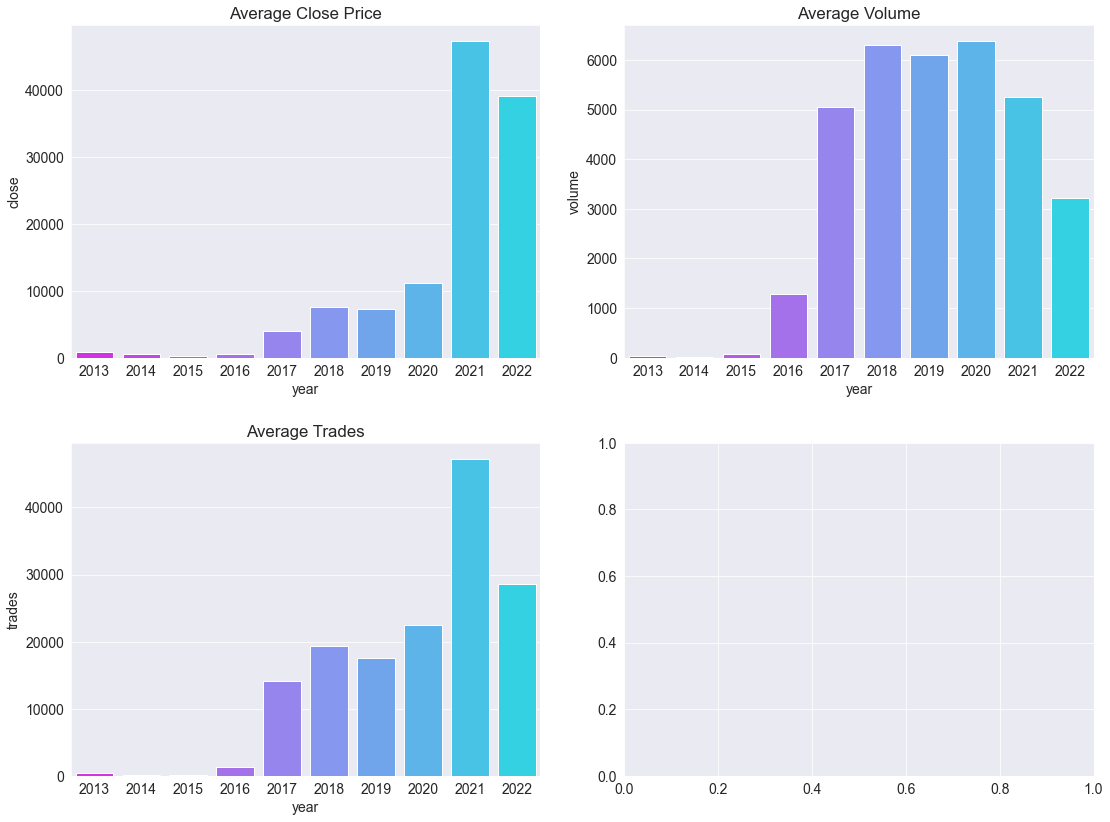

In [225]:
fig, axes = plt.subplots(2,2, figsize=(16,12))

axes[0,0].set_title("Average Close Price")
sns.barplot(ax=axes[0,0], data = btc_avg, x = btc_avg.index, y=btc_avg["close"], palette="cool_r")

axes[0,1].set_title("Average Volume")
sns.barplot(ax=axes[0,1], data = btc_avg, x = btc_avg.index, y=btc_avg["volume"],palette="cool_r")


axes[1,0].set_title("Average Trades",)
sns.barplot(ax=axes[1,0], data = btc_avg, x = btc_avg.index, y=btc_avg["trades"],palette="cool_r")


plt.tight_layout(pad=2)

In [226]:
#df_2013 = btc_df_viz[btc_df_viz["year"]==2013]
#df_2014 = btc_df_viz[btc_df_viz["year"]==2014]
#df_2015 = btc_df_viz[btc_df_viz["year"]==2015]
#df_2016 = btc_df_viz[btc_df_viz["year"]==2016]
#df_2017 = btc_df_viz[btc_df_viz["year"]==2017]
#df_2018 = btc_df_viz[btc_df_viz["year"]==2018]
#df_2019 = btc_df_viz[btc_df_viz["year"]==2019]
#df_2020 = btc_df_viz[btc_df_viz["year"]==2020]
#df_2021 = btc_df_viz[btc_df_viz["year"]==2021]
#df_2022 = btc_df_viz[btc_df_viz["year"]==2022]

#### Heatmap showing  correlation score

In [227]:
cor_df= btc_df_viz.corr()

<AxesSubplot:>

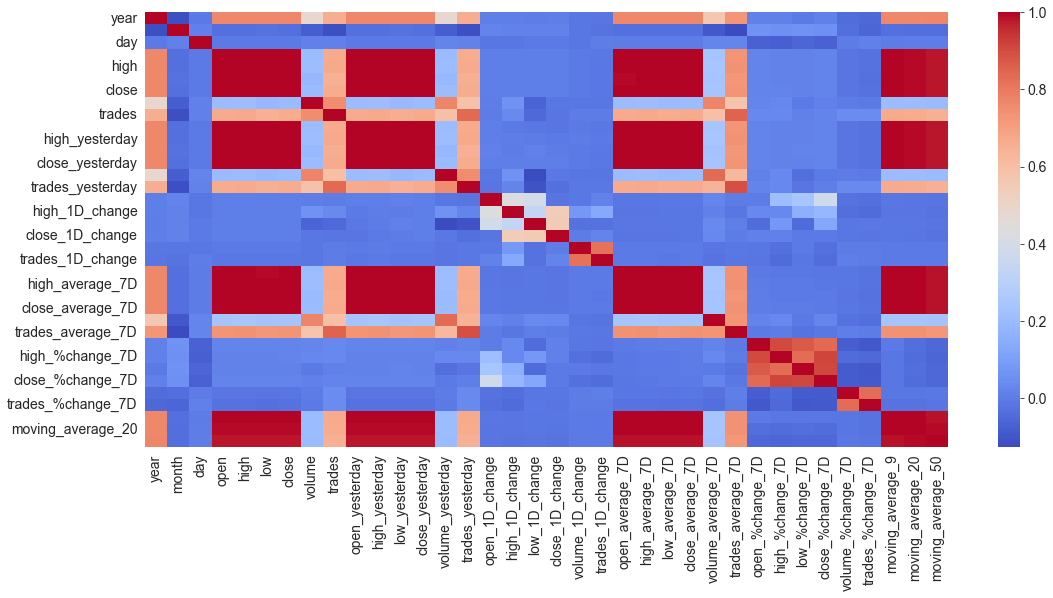

In [228]:
sns.heatmap(cor_df, cmap="coolwarm")

#### DataFrame with Dropping some Features

In [229]:
btc_df_less_features = btc_df.drop(["year", "month", "day"], axis=1) # not important

In [230]:
btc_df_less_features = btc_df_less_features.drop(["open", "high", "low","trades", "volume"], axis=1) 

# in reality, we don't know this on the current day or tomorrow day we want to predict
# we only know yesterday'open, yesterday'high, yesterday's low, and yesterday's close

In [231]:
btc_df_less_features.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,1165.42500,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


<b> Save dataframe for machine learning model </b>

In [232]:
btc_df_less_features.to_csv("data/btc_df_less_features.csv")

## MACHINE LEARNING MODEL

* Split train-test data using date since it's a time series data

* not using train-test-split from sklearn since it will mix up the data

In [233]:
btc_ml_all = pd.read_csv("data/btc_df_less_features.csv", index_col=0)

In [234]:
btc_ml_all.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,1165.42500,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [235]:
btc_ml_all.tail(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-03,29676.4,29790.0,31449.2,29572.8,30427.0,2470.229023,19405.0,-0.062647,-0.015027,0.008326,0.021383,-0.522312,-0.381672,29928.271429,30876.442857,29276.714286,30108.571429,3377.918417,24755.571429,0.010495,0.008596,0.001014,0.002066,0.498077,0.160941,29940.800000,29876.625,34388.020
2022-06-04,29850.0,30431.3,30658.9,29255.0,29676.4,2472.705420,18044.0,0.021527,-0.025129,-0.010746,-0.024669,0.001002,-0.070137,30109.042857,31058.214286,29420.285714,30265.200000,3100.954225,23052.571429,0.002069,0.008034,0.010997,0.006734,0.315893,0.029863,29958.144444,29858.035,34182.450
2022-06-05,29768.3,29676.4,29954.5,29450.1,29850.0,783.344337,10432.0,-0.024807,-0.022975,0.006669,0.005850,-0.683204,-0.421858,30265.671429,31161.857143,29556.000000,30383.771429,3044.968723,22382.000000,0.006855,0.006682,0.005592,0.006180,0.331916,0.016631,30031.822222,29785.690,33968.052


#### Drop the last row because we want to predict the price of the current day

In [236]:
last_row = btc_ml_all[-1:]
last_row

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-05,29768.3,29676.4,29954.5,29450.1,29850.0,783.344337,10432.0,-0.024807,-0.022975,0.006669,0.00585,-0.683204,-0.421858,30265.671429,31161.857143,29556.0,30383.771429,3044.968723,22382.0,0.006855,0.006682,0.005592,0.00618,0.331916,0.016631,30031.822222,29785.69,33968.052


In [237]:
btc_ml = btc_ml_all[:-1]
btc_ml.head(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [238]:
btc_ml.tail(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-03,29676.4,29790.0,31449.2,29572.8,30427.0,2470.229023,19405.0,-0.062647,-0.015027,0.008326,0.021383,-0.522312,-0.381672,29928.271429,30876.442857,29276.714286,30108.571429,3377.918417,24755.571429,0.010495,0.008596,0.001014,0.002066,0.498077,0.160941,29940.800000,29876.625,34388.02
2022-06-04,29850.0,30431.3,30658.9,29255.0,29676.4,2472.705420,18044.0,0.021527,-0.025129,-0.010746,-0.024669,0.001002,-0.070137,30109.042857,31058.214286,29420.285714,30265.200000,3100.954225,23052.571429,0.002069,0.008034,0.010997,0.006734,0.315893,0.029863,29958.144444,29858.035,34182.45


#### Split train-test 85:15
* Can't use train-test split because it will shuffle the data/date index

In [239]:
len(btc_ml)

3102

In [240]:
train_size = (85*(len(btc_ml)))//100
train_size

2636

**Train Set**

In [241]:
train_set = btc_ml.iloc[0:train_size]
train_set.tail(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-21,57478.3,55926.5,57500.0,53961.9,55938.7,5846.246813,68544.0,0.084046,0.020410,0.064686,0.000211,-0.274280,-0.090808,50375.000000,52646.828571,49186.600000,51628.857143,5772.530574,61861.857143,0.010760,0.020834,0.013400,0.024277,0.172429,0.080711,50674.700000,45096.18,38999.830
2021-02-22,54154.8,55931.5,58339.0,55490.5,57478.3,3727.835736,45876.0,0.000089,0.014591,0.028327,0.027523,-0.362354,-0.330707,51622.371429,53880.971429,50394.000000,52890.085714,5797.491088,61187.857143,0.024379,0.025796,0.022573,0.025122,0.205594,0.118804,51786.688889,46293.40,39504.620
2021-02-23,48899.8,57475.9,57567.6,45002.0,54154.8,12299.535705,125363.0,0.027612,-0.013223,-0.189014,-0.057822,2.299377,1.732649,52882.442857,55098.728571,50292.785714,53778.328571,6791.996297,70336.000000,0.025110,0.023508,0.024293,0.024665,0.103820,0.030814,52559.455556,47226.14,39926.062


**Test Set**

In [242]:
test_set = btc_ml[train_size:]
test_set.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-24,49727.7,54128.0,54200.0,45000.0,48899.8,17080.212490,157669.0,-0.058249,-0.058498,-0.000044,-0.097037,0.388688,0.257700,53766.857143,55613.028571,50001.342857,53732.771429,8349.809410,83729.714286,0.024649,0.023507,0.001325,0.018498,0.360539,0.248032,52587.244444,47787.585,40263.098
2021-02-25,47061.5,48899.6,51442.5,47015.7,49727.7,8110.232977,75094.0,-0.096593,-0.050876,0.044793,0.016931,-0.525168,-0.523724,53726.000000,55422.014286,49722.528571,53389.585714,8462.580260,84806.714286,0.018437,0.010616,-0.002837,0.000816,0.393652,0.278820,52786.200000,48425.020,40576.652
2021-02-26,46314.5,49726.1,52071.9,46702.0,47061.5,7523.627857,69227.0,0.016902,0.012235,-0.006672,-0.053616,-0.072329,-0.078129,53382.585714,55352.985714,49122.214286,52741.100000,8949.069152,88166.142857,0.000917,-0.002806,-0.002291,-0.005215,0.292134,0.195862,52546.511111,48863.260,40780.348


**X_train, y_train, X_test, y_test**

<b>X_train</b>

In [243]:
X_train_new = train_set.drop(["close"], axis=1)
X_train_new.head(3)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [244]:
X_train = X_train_new.values
X_train.shape

(2636, 27)

<b>X_test</b>

In [245]:
X_test_new = test_set.drop(["close"], axis=1)

In [246]:
X_test_new.head(3)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-24,54128.0,54200.0,45000.0,48899.8,17080.212490,157669.0,-0.058249,-0.058498,-0.000044,-0.097037,0.388688,0.257700,53766.857143,55613.028571,50001.342857,53732.771429,8349.809410,83729.714286,0.024649,0.023507,0.001325,0.018498,0.360539,0.248032,52587.244444,47787.585,40263.098
2021-02-25,48899.6,51442.5,47015.7,49727.7,8110.232977,75094.0,-0.096593,-0.050876,0.044793,0.016931,-0.525168,-0.523724,53726.000000,55422.014286,49722.528571,53389.585714,8462.580260,84806.714286,0.018437,0.010616,-0.002837,0.000816,0.393652,0.278820,52786.200000,48425.020,40576.652
2021-02-26,49726.1,52071.9,46702.0,47061.5,7523.627857,69227.0,0.016902,0.012235,-0.006672,-0.053616,-0.072329,-0.078129,53382.585714,55352.985714,49122.214286,52741.100000,8949.069152,88166.142857,0.000917,-0.002806,-0.002291,-0.005215,0.292134,0.195862,52546.511111,48863.260,40780.348


In [247]:
X_test = X_test_new.values
X_test.shape

(466, 27)

<b> y_train </b>

In [248]:
y_train_new = train_set["close"]

In [249]:
y_train = y_train_new.values
y_train.shape

(2636,)

<b>y_test</b>

In [250]:
y_test_new = test_set["close"]
y_test = y_test_new.values
y_test.shape

(466,)

## Support Vector Machine

In [251]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import mean_squared_error, r2_score
from sklearn.svm import SVR

### Scale featues

In [252]:
scaler = StandardScaler()

In [253]:
X_scaled_train = scaler.fit_transform(X_train)

In [254]:
X_scaled_test = scaler.transform(X_test) 
# not using fit to avoid data leakage 

### Base Model1:  Not Scale and Not Adjust Parameters

In [255]:
svr_base1 = SVR()

In [256]:
svr_base1.fit(X_train , y_train)

SVR()

In [257]:
pred_base1 = svr_base1.predict(X_test)

In [258]:
print(np.sqrt(mean_squared_error(y_test, pred_base1)))

43908.37246282376


In [259]:
print(r2_score(y_test, pred_base1))

-20.61275638329084


### Base Model2: Scale but Not Adjust Parameters

In [260]:
svr_base2 = SVR()

In [261]:
svr_base2.fit(X_scaled_train, y_train)

SVR()

In [262]:
pred_base2 = svr_base2.predict(X_scaled_test)

In [263]:
print(np.sqrt(mean_squared_error(y_test, pred_base2)))

43818.85695395269


In [264]:
print(r2_score(y_test, pred_base2))

-20.52472284092685


### Model 3: Adjusted Model: Scale + Adjust Parameters

In [265]:
param_grid = {'kernel': ['linear'], 'C': [100,300, 500], 'epsilon': [0.00001, 0.0001, 0.001]}

In [266]:
svr = SVR()

In [267]:
%%time
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2')

CPU times: user 72 µs, sys: 345 µs, total: 417 µs
Wall time: 709 µs


In [268]:
%%time
grid_search.fit(X_scaled_train, y_train)

CPU times: user 1min 16s, sys: 355 ms, total: 1min 16s
Wall time: 1min 17s


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [100, 300, 500],
                         'epsilon': [1e-05, 0.0001, 0.001],
                         'kernel': ['linear']},
             scoring='r2')

In [269]:
%%time
print(grid_search.best_params_)

{'C': 500, 'epsilon': 0.001, 'kernel': 'linear'}
CPU times: user 133 µs, sys: 42 µs, total: 175 µs
Wall time: 176 µs


In [270]:
svr_best = grid_search.best_estimator_

In [271]:
pred_svr_adjusted = svr_best.predict(X_scaled_test)

In [272]:
print(np.sqrt(mean_squared_error(y_test, pred_svr_adjusted)))

1761.3050239271267


In [273]:
print(r2_score(y_test, pred_svr_adjusted))

0.9652235996534333


In [274]:
len(y_test)

466

In [275]:
len(pred_svr_adjusted)

466

In [276]:
test_set["close"]

date
2021-02-24    49727.7
2021-02-25    47061.5
2021-02-26    46314.5
2021-02-27    46170.2
2021-02-28    45245.4
               ...   
2022-05-31    31780.9
2022-06-01    29790.0
2022-06-02    30427.0
2022-06-03    29676.4
2022-06-04    29850.0
Name: close, Length: 466, dtype: float64

In [277]:
df_compare = pd.DataFrame(columns=["actual_price", "predicted_price"])

In [278]:
df_compare

,actual_price,predicted_price


In [279]:
df_compare["actual_price"] = test_set["close"]

In [280]:
df_compare["predicted_price"] = pred_svr_adjusted

In [281]:
df_compare["difference"] =  df_compare["actual_price"] - df_compare["predicted_price"] 

In [282]:
df_compare.head(10)

,actual_price,predicted_price,difference
date,,,
2021-02-24,49727.7,49420.489757,307.210243
2021-02-25,47061.5,49928.792565,-2867.292565
2021-02-26,46314.5,48482.567344,-2168.067344
2021-02-27,46170.2,46607.159911,-436.959911
2021-02-28,45245.4,46667.842827,-1422.442827
2021-03-01,49620.7,45185.925449,4434.774551
2021-03-02,48486.2,48807.928985,-321.728985
2021-03-03,50400.0,48525.212834,1874.787166
2021-03-04,48330.0,50455.372225,-2125.372225


In [283]:
df_compare.tail(15)

,actual_price,predicted_price,difference
date,,,
2022-05-21,29403.5,29210.428989,193.071011
2022-05-22,30268.0,29200.773575,1067.226425
2022-05-23,29070.0,29955.652453,-885.652453
2022-05-24,29631.8,29211.929281,419.870719
2022-05-25,29520.3,29345.857867,174.442133
2022-05-26,29186.9,29539.037873,-352.137873
2022-05-27,28580.0,28827.024431,-247.024431
2022-05-28,29020.0,28611.964312,408.035688
2022-05-29,29450.4,28909.769347,540.630653


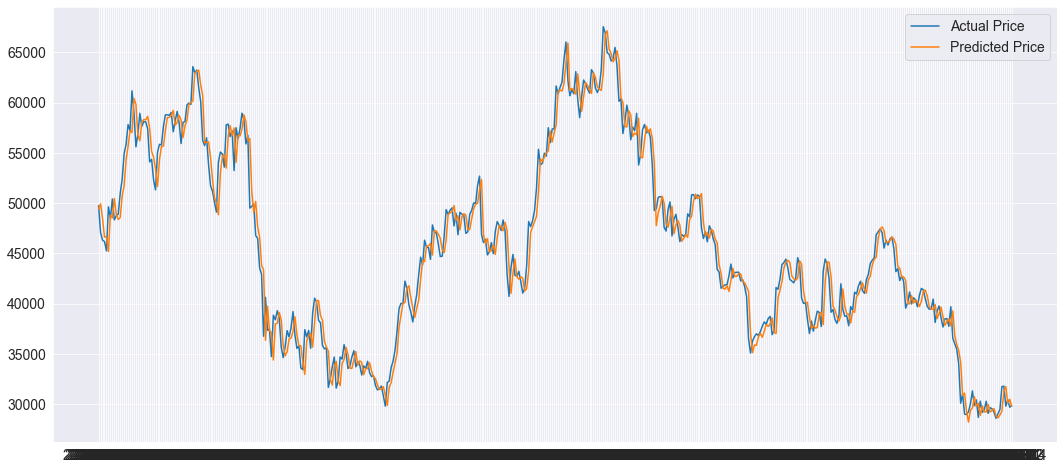

In [284]:
plt.plot(df_compare.index , df_compare.actual_price, label="Actual Price")
plt.plot(df_compare.index , df_compare.predicted_price, label="Predicted Price")
plt.legend()
plt.show()


# LIVE PREDICTION

* This section is trying to test the model performance on live prediction
* The model will predict the price the next day
* Therefore, there will be only one row of test set 
* y_test will be known at the end of trading day

#### 1. Dataset is from 2013 to Current day

In [285]:
btc_ml.head(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [286]:
btc_ml.tail(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-03,29676.4,29790.0,31449.2,29572.8,30427.0,2470.229023,19405.0,-0.062647,-0.015027,0.008326,0.021383,-0.522312,-0.381672,29928.271429,30876.442857,29276.714286,30108.571429,3377.918417,24755.571429,0.010495,0.008596,0.001014,0.002066,0.498077,0.160941,29940.800000,29876.625,34388.02
2022-06-04,29850.0,30431.3,30658.9,29255.0,29676.4,2472.705420,18044.0,0.021527,-0.025129,-0.010746,-0.024669,0.001002,-0.070137,30109.042857,31058.214286,29420.285714,30265.200000,3100.954225,23052.571429,0.002069,0.008034,0.010997,0.006734,0.315893,0.029863,29958.144444,29858.035,34182.45


#### 2. Training Set is from 2013 to yesterday price

<b> X_train</b>

In [287]:
X_train_new2 = btc_ml.drop(["close"], axis=1)
X_train_new2.head(2)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [288]:
X_train_new2.tail(2)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-03,29790.0,31449.2,29572.8,30427.0,2470.229023,19405.0,-0.062647,-0.015027,0.008326,0.021383,-0.522312,-0.381672,29928.271429,30876.442857,29276.714286,30108.571429,3377.918417,24755.571429,0.010495,0.008596,0.001014,0.002066,0.498077,0.160941,29940.800000,29876.625,34388.02
2022-06-04,30431.3,30658.9,29255.0,29676.4,2472.705420,18044.0,0.021527,-0.025129,-0.010746,-0.024669,0.001002,-0.070137,30109.042857,31058.214286,29420.285714,30265.200000,3100.954225,23052.571429,0.002069,0.008034,0.010997,0.006734,0.315893,0.029863,29958.144444,29858.035,34182.45


In [289]:
X_train2 = X_train_new2.values
X_train2.shape

(3102, 27)

<b> y_train </b>

In [290]:
y_train_new = btc_ml["close"]
y_train2 = y_train_new.values
y_train2.shape

(3102,)

#### 3. Test set is current trading day , today ( the last row)

In [291]:
X_test2 = last_row.drop(["close"], axis=1)
X_test2

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-06-05,29676.4,29954.5,29450.1,29850.0,783.344337,10432.0,-0.024807,-0.022975,0.006669,0.00585,-0.683204,-0.421858,30265.671429,31161.857143,29556.0,30383.771429,3044.968723,22382.0,0.006855,0.006682,0.005592,0.00618,0.331916,0.016631,30031.822222,29785.69,33968.052


<b> y_actual </b>

#### 4. Model Prediciton

In [292]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import mean_squared_error, r2_score
from sklearn.svm import SVR

### Scale featues

In [293]:
scaler = StandardScaler()

In [294]:
X_scaled_train2 = scaler.fit_transform(X_train2)

In [295]:
X_scaled_test2 = scaler.transform(X_test2) # not using fit to avoid data leakage 

/Users/daranee/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [296]:
param_grid2 = {'kernel': ['linear'], 'C': [100,300, 500], 'epsilon': [0.00001, 0.0001, 0.001]}

In [297]:
svr2 = SVR()

In [298]:
%%time
grid_search2 = GridSearchCV(svr2, param_grid2, cv=5, scoring='r2')

CPU times: user 61 µs, sys: 335 µs, total: 396 µs
Wall time: 618 µs


In [299]:
%%time
grid_search2.fit(X_scaled_train2, y_train2)

CPU times: user 1min 17s, sys: 333 ms, total: 1min 18s
Wall time: 1min 18s


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [100, 300, 500],
                         'epsilon': [1e-05, 0.0001, 0.001],
                         'kernel': ['linear']},
             scoring='r2')

In [300]:
%%time
print(grid_search2.best_params_)

{'C': 500, 'epsilon': 1e-05, 'kernel': 'linear'}
CPU times: user 149 µs, sys: 106 µs, total: 255 µs
Wall time: 218 µs


In [301]:
svr_best2 = grid_search2.best_estimator_

In [302]:
pred_svr_adjusted2 = svr_best2.predict(X_scaled_test2)

In [303]:
pred_svr_adjusted2

array([29786.25381176])

#### Create a new dataframe 

In [304]:
new_cols = ["date","predict", "actual"]

In [148]:
df_actual = pd.DataFrame(columns=new_cols)
df_actual

,date,predict,actual


In [149]:
df_actual["date"] = last_row.index
df_actual

,date,predict,actual
0,2022-06-04,NaN,NaN


In [150]:
df_actual["predict"] = pred_svr_adjusted2
df_actual

,date,predict,actual
0,2022-06-04,29829.815486,NaN


## Run Every Day

### Run at the End Of Day ( 5 p.m. Pacific Time)

In [151]:
daily_predict = pd.read_csv("data/daily_predict.csv", index_col=0)
daily_predict

,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,30427.0,-197.475694
8,2022-06-03,30475.550098,NaN,NaN


### Actual Result

In [152]:
actual_close = btc_ml["close"][-1]
actual_close

29676.4

In [153]:
#daily_predict.set_index("date")

In [154]:
daily_predict["actual"][-1:] =  actual_close
daily_predict

/var/folders/77/506sgzjs15b84ns9yp8cp2rc0000gn/T/ipykernel_30974/2655483848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_predict["actual"][-1:] =  actual_close


,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,30427.0,-197.475694
8,2022-06-03,30475.550098,29676.4,NaN


In [155]:
daily_predict["difference"] = daily_predict["predict"] - daily_predict["actual"]
daily_predict

,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,30427.0,-197.475694
8,2022-06-03,30475.550098,29676.4,799.150098


### Store Updated data everyday

In [156]:
daily_predict = daily_predict.append(df_actual, ignore_index=True)
daily_predict

/var/folders/77/506sgzjs15b84ns9yp8cp2rc0000gn/T/ipykernel_30974/4107255893.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  daily_predict = daily_predict.append(df_actual, ignore_index=True)


,date,predict,actual,difference
0,2022-05-26,29070.000000,29186.9,-116.900000
1,2022-05-27,28970.105130,28580.0,390.105130
2,2022-05-28,28707.510872,29020.0,-312.489128
3,2022-05-29,28931.565188,29450.4,-518.834812
4,2022-05-30,29302.727938,31711.7,-2408.972062
5,2022-05-31,31233.164985,31780.9,-547.735015
6,2022-06-01,31797.861554,29790.0,2007.861554
7,2022-06-02,30229.524306,30427.0,-197.475694
8,2022-06-03,30475.550098,29676.4,799.150098
9,2022-06-04,29829.815486,NaN,NaN


In [157]:
daily_predict.to_csv("data/daily_predict.csv")